In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
from complexPyTorch.complexLayers import ComplexLinear
from complexPyTorch.complexFunctions import complex_relu
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

In [2]:
####### 生成数据：N个样本，每个样本8个复数特征
N = 1000000
k = 8
snr = 1 # 信号与噪声幅值之比
# 合并信号和噪声
X = np.zeros((N, k), dtype=np.complex64)
X[:N//2, :] = np.random.randn(N//2, k) + 1j * np.random.randn(N//2, k) # 噪声
X[N//2:, :] = snr*(np.random.randn(N//2, k) + 1j * np.random.randn(N//2, k)) + X[:N//2, :] # 信号加噪声

# 转换为torch.complex64类型
X_complex_tensor = torch.tensor(X, dtype=torch.complex64)

# 生成标签：前N/2个标签为[0, 1]，后N/2个标签为[1, 0]（one-hot编码）
y = np.zeros((N, 2))  # 初始化标签为[0, 0]，大小为(N, 2)
y[:N//2, 0] = 1  # 前N/2个标签设为[1, 0]
y[N//2:, 1] = 1  # 后N/2个标签设为[0, 1]

# 划分数据集，80%作为训练集，20%作为测试集
X_train, _, y_train,_= train_test_split(X_complex_tensor.numpy(), y, test_size=0.8, random_state=42)

##########################################测试集################################################# 
# 合并信号和噪声
snr = 1 # 信号与噪声幅值之比
# 合并信号和噪声
X = np.zeros((N, k), dtype=np.complex64)
X[:N//2, :] = np.random.randn(N//2, k) + 1j * np.random.randn(N//2, k) # 噪声
X[N//2:, :] = snr*(np.random.randn(N//2, k) + 1j * np.random.randn(N//2, k)) + X[:N//2, :] # 信号加噪声

# 转换为torch.complex64类型
X_complex_tensor = torch.tensor(X, dtype=torch.complex64)

# 转换为torch.complex64类型
X_complex_tensor = torch.tensor(X, dtype=torch.complex64)
_, X_test, _, y_test = train_test_split(X_complex_tensor.numpy(), y, test_size=0.8, random_state=42)
####
# 转换为 PyTorch 张量
X_train_tensor = torch.tensor(X_train, dtype=torch.complex64)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.complex64)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


In [3]:
########### 构建神经网络模型
def complexRelu(z):
    # """
    # 实现一个复数 ReLU 函数：
    # - 如果复数的角度在 0 到 pi/2 之间，返回原复数；
    # - 否则返回 0 + 0j。
    # """
    # 获取复数的相位
    angle = torch.angle(z)
    # 判断相位是否在 [0, pi/2] 之间
    mask = (angle >= 0) & (angle <= torch.pi / 2)
    # 使用 mask 来选择复数值
    result = torch.where(mask, z, torch.zeros_like(z))
    return result
    
class MLPModel(nn.Module):
    
    def __init__(self):
        super(MLPModel, self).__init__()
        self.fc1 = ComplexLinear(8, 30)  # 输入层到第一隐藏层（每个样本8个复数特征）
        self.fc2 = ComplexLinear(30, 32)  # 第一隐藏层到第二隐藏层
        self.fc3 = ComplexLinear(32, 2)  

    def forward(self, x):
        # 网络的后续传播
        # x = complexRelu(self.fc1(x))  # 第一层激活
        # x = complexRelu(self.fc2(x))  # 第二层激活
        x = complex_relu(self.fc1(x))  # 第一层激活
        x = complex_relu(self.fc2(x))  # 第二层激活 
        x = self.fc3(x)  # 输出层
        x = torch.abs(x)**2
        return x
    
# 创建模型
model = MLPModel()

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()  # 多类别交叉熵损失
complex_optim = optim.AdamW(model.parameters(), lr=0.001)


In [4]:
# 训练模型
num_epochs = 1000
for epoch in range(num_epochs):
    # 前向传播
    y_pred = model(X_train_tensor)
    loss = criterion(y_pred, y_train_tensor)
    
    # 反向传播和优化
    complex_optim.zero_grad()
    loss.backward()
    complex_optim.step()
    
    # 打印训练过程中的损失
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")


Epoch [10/1000], Loss: 0.6721
Epoch [20/1000], Loss: 0.6462
Epoch [30/1000], Loss: 0.6176
Epoch [40/1000], Loss: 0.5748
Epoch [50/1000], Loss: 0.5153
Epoch [60/1000], Loss: 0.4606
Epoch [70/1000], Loss: 0.4275
Epoch [80/1000], Loss: 0.4092
Epoch [90/1000], Loss: 0.3991
Epoch [100/1000], Loss: 0.3934
Epoch [110/1000], Loss: 0.3900
Epoch [120/1000], Loss: 0.3877
Epoch [130/1000], Loss: 0.3860
Epoch [140/1000], Loss: 0.3845
Epoch [150/1000], Loss: 0.3834
Epoch [160/1000], Loss: 0.3827
Epoch [170/1000], Loss: 0.3815
Epoch [180/1000], Loss: 0.3808
Epoch [190/1000], Loss: 0.3802
Epoch [200/1000], Loss: 0.3796
Epoch [210/1000], Loss: 0.3792
Epoch [220/1000], Loss: 0.3789
Epoch [230/1000], Loss: 0.3783
Epoch [240/1000], Loss: 0.3779
Epoch [250/1000], Loss: 0.3775
Epoch [260/1000], Loss: 0.3772
Epoch [270/1000], Loss: 0.3775
Epoch [280/1000], Loss: 0.3767
Epoch [290/1000], Loss: 0.3763
Epoch [300/1000], Loss: 0.3760
Epoch [310/1000], Loss: 0.3758
Epoch [320/1000], Loss: 0.3755
Epoch [330/1000],

In [5]:
# 门限范围
thresholds = [1e-6,1e-5,1e-4,1e-3,1e-2,5e-2,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9] #虚警率
# 用于保存每个门限下的虚警率和检测率
far_values = []
pd_values = []
# 测试模型
for threshold in tqdm(thresholds, desc="Testing thresholds"):
    with torch.no_grad():
        y_test_pred = model(X_test_tensor)
        y_test_pred = F.softmax(y_test_pred, dim=1)
        # 获取预测值0的概率
        prob_class_0 = y_test_pred[:, 0]

        # 根据当前门限判断预测类别：如果预测值0的概率大于当前门限，则选择类别0，否则选择类别1
        y_test_pred_class = torch.where(prob_class_0 > threshold, torch.tensor(0), torch.tensor(1))

        # 计算混淆矩阵
        y_test_true_class = torch.max(y_test_tensor,1)[1]  # 获取真实类别的索引
        tn, fp, fn, tp = confusion_matrix(y_test_true_class.numpy(), y_test_pred_class.numpy()).ravel()

        # 计算虚警率 (PRF)
        false_alarm_rate = fp / (tn + fp) if (tn + fp) > 0 else 0

        # 计算检测率 (PD)
        detection_rate = tp / (tp + fn) if (tp + fn) > 0 else 0

        # 保存虚警率和检测率
        far_values.append(false_alarm_rate)
        pd_values.append(detection_rate)


Testing thresholds: 100%|██████████| 15/15 [00:05<00:00,  2.70it/s]


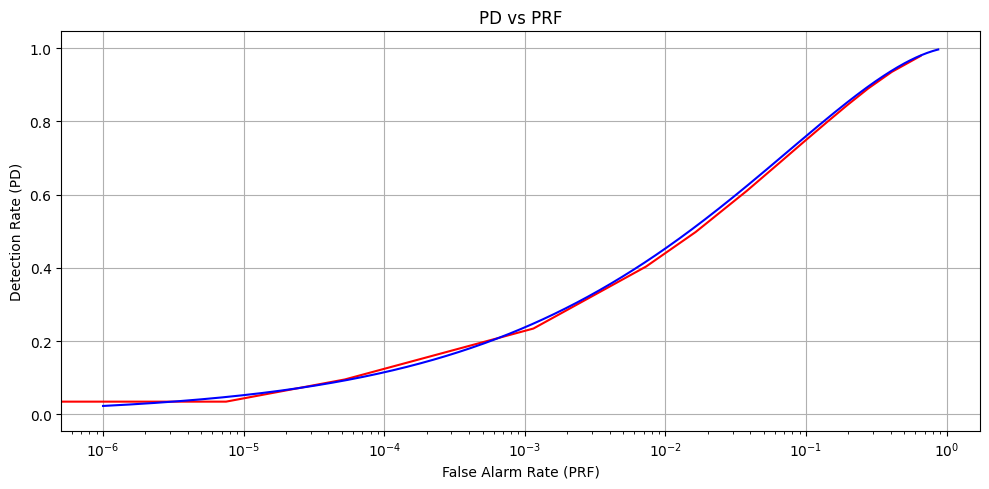

In [7]:
# 绘制门限与虚警率的关系图
plt.figure(figsize=(10, 5))

# 绘制 PD vs PRF 图
plt.semilogx(far_values, pd_values, label="Deep Learning", color='red')

# # 加载理论数据并绘制
data = np.load("prf_pd_untheory.npz")
pfa_Theory = data['pfa']
pd_theory = data['pd']
plt.semilogx(pfa_Theory, pd_theory, label="Theory", color='blue')

plt.xlabel("False Alarm Rate (PRF)")
plt.ylabel("Detection Rate (PD)")
plt.title("PD vs PRF")
plt.grid(True)

# 显示图表
plt.tight_layout()
plt.show()